**Задание 1.**

Реализуйте полносвязную нейронную сеть с помощью библиотеки Tensor Flow. В качестве алгоритма оптимизации можно использовать, например, стохастический градиент (Stochastic Gradient Descent, SGD). Определите количество скрытых слоев от 1 до 5, количество нейронов в каждом из слоев до нескольких сотен, а также их функции активации (кусочно-линейная, сигмоидная, гиперболический тангенс и т.д.).

**Задание 2.**

Как улучшилась точность классификатора по сравнению с логистической регрессией?

**Задание 3.**

Используйте регуляризацию и метод сброса нейронов (dropout) для борьбы с переобучением. Как улучшилось качество классификации?

**Задание 4.**

Воспользуйтесь динамически изменяемой скоростью обучения (learning rate). Наилучшая точность, достигнутая с помощью данной модели составляет 97.1%. Какую точность демонстрирует Ваша реализованная модель?

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import numpy as np
import tensorflow as tf
import scipy.io
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [5]:
tf.__version__

'1.14.0'

In [6]:
large_dataset_path = '../../lab_1/src/notMNIST_large_clean.mat'
small_dataset_path = '../../lab_1/src/notMNIST_small_uniq.mat'

In [7]:
chars = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [8]:
def prepare_dataset(dataset, records=None):
    data = list()
    labels = list()

    lb = preprocessing.LabelBinarizer()
    lb.fit(chars)
    
    if records:
        one = int(records / len(chars))
        #check
        for ch in chars:
            ch_len = len(dataset[ch])
            assert ch_len >= one, f'"{ch}" has {ch_len} items but required {one}'
        #print(one)
        for ch in chars:
            indexes = np.random.choice(len(dataset[ch]), one)
            picked_elements = dataset[ch][indexes] / 255
            data.extend(picked_elements)
            labels.extend(np.tile(lb.transform([ch])[0], (one, 1)))
    else:
        for ch in chars:
            data.extend(dataset[ch]/255)
            labels.extend(np.tile(lb.transform([ch])[0], (len(dataset[ch]), 1)))
    
    data = np.array(data)
    labels = np.array(labels)
    
    return resample(data, labels)

In [9]:
small_data = scipy.io.loadmat(small_dataset_path)
test_X, test_y = prepare_dataset(small_data)

In [10]:
large_data = scipy.io.loadmat(large_dataset_path)
train_X, train_y = prepare_dataset(large_data, 400000)
train_X.shape

(400000, 784)

In [11]:
g_epochs = 150
g_batch_size = 256

In [12]:
class Lab2Model():
    def __init__(self, var_scope, layers_info, reg=0.0, dropout=0.0, lr=0.003, adaptive_lr=False):
        self.var_scope = var_scope
        self.layers_info = layers_info
        self.layers_count = len(layers_info)
        self.regularization = reg
        self.dropout = dropout
        self.learning_rate = lr
        self.learning_rate_adaptive = adaptive_lr
        self.session = None
    
    def __del__(self): 
        if self.session:
            self.session.close()
        
    def compile(self):
        self.input = tf.placeholder(tf.float32, shape=[None, self.layers_info[0]])
        self.expected_output = tf.placeholder(tf.float32, shape=[None, self.layers_info[-1]])
        
        self.hidden_layers = {}
        self.hidden_layers_W = {}
        self.hidden_layers_b = {}
        
        self.dropout_rate = tf.placeholder(tf.float32)
        
        prev_layer = self.input
        
        for layer_idx in self.__hidden_layer_iter():            
            units = self.layers_info[layer_idx]
            self.hidden_layers[layer_idx] = self.__fc_layer(layer_idx, prev_layer, units)
            prev_layer = self.hidden_layers[layer_idx]
        
        self.output_layer = self.__fc_layer(self.layers_count - 1, prev_layer, self.layers_info[-1], activ=None)
        
        self.loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.expected_output, logits=self.output_layer)
        )
        
        if self.regularization:
            reg_sum = 0
            for layer_idx in self.__hidden_layer_iter():  
                reg_sum += tf.nn.l2_loss(self.hidden_layers_W[layer_idx])
            
            self.loss = tf.reduce_mean(self.loss + reg_sum * self.regularization)
        
        self.lr = tf.placeholder(tf.float32, shape=[])
        
        self.optimizer = tf.train.GradientDescentOptimizer(
            learning_rate=self.learning_rate
        ).minimize(self.loss)
        
        self.prediction = tf.nn.softmax(self.output_layer)
        self.accuracy = tf.reduce_mean(
            tf.cast(
                tf.equal(tf.argmax(self.prediction, 1), tf.argmax(self.expected_output, 1)),
                tf.float32,
            )
        )
                
        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())
        
        self.history = {
            'acc_train': [],
            'acc_valid': [],
            'loss_train': [],
            'loss_valid': []
        }
    
    def fit(self, x=None, y=None, batch_size=64, epochs=1):
        
        valid_size = 0.3
        
        if len(y) * valid_size > 20_000:
            valid_size = 20_000
        
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=valid_size, random_state=50)
        
        print(f'Train size: {len(y_train)},\t Valid size: {len(y_valid)}')
        
        iterations = int(len(y_train) / batch_size)
        
        display_info = int(iterations / 2)
        
        print(f'---------------------------------------------------------------')
        print(f'Epochs: {epochs}\t| Iterations: {iterations}\t| Batch: {batch_size}')
        print(f'---------------------------------------------------------------')
        
        for epoch in range(epochs):
            print('Epoch: {}'.format(epoch + 1))
            
            x_train_epoch, y_train_epoch = resample(x_train, y_train)
            
            lr = self.__next_lr(epoch, epochs)
            #print(lr)
            
            for iteration in range(iterations):
                x_batch, y_batch = self.__next_batch(x_train_epoch, y_train_epoch, batch_size, iteration)

                feed_data = { 
                    self.input: x_batch, 
                    self.expected_output: y_batch, 
                    self.lr: lr, 
                    self.dropout_rate: self.dropout
                }
                
                self.session.run(self.optimizer, feed_dict=feed_data)
                
                #if iteration % display_info == 0:
                #    info_feed_data = { self.input: x_batch, self.expected_output: y_batch, self.dropout_rate: 0}
                #    loss_batch, acc_batch = self.session.run([self.loss, self.accuracy], feed_dict=info_feed_data)
                #    print(f'Itr {iteration}:\t loss={loss_batch:.2f},\t acc={acc_batch:.01%}')
        
        
            feed_data_train = { self.input: x_train, self.expected_output: y_train, self.dropout_rate: 0}
            loss_train, acc_train = self.session.run([self.loss, self.accuracy], feed_dict=feed_data_train)

            self.history['acc_train'].append(acc_train)
            self.history['loss_train'].append(loss_train)

            feed_data_valid = { self.input: x_valid, self.expected_output: y_valid, self.dropout_rate: 0}
            loss_valid, acc_valid = self.session.run([self.loss, self.accuracy], feed_dict=feed_data_valid)

            self.history['acc_valid'].append(acc_valid)
            self.history['loss_valid'].append(loss_valid)

            print('---------------------------------------------------------')
            print('---------------------------------------------------------')
            print(f'train loss: {loss_train:.2f}, train acc: {acc_train:.01%}')
            print(f'valid loss: {loss_valid:.2f}, valid acc: {acc_valid:.01%}')
            print('---------------------------------------------------------')
            print('---------------------------------------------------------')
    
    def predict(self, x=None):
        feed_data = { self.input: x, self.dropout_rate: 0}
        return self.session.run(self.prediction, feed_dict=feed_data)
    
    def evaluate(self, x=None, y=None):
        feed_data = { self.input: x, self.expected_output: y, self.dropout_rate: 0}
        return self.session.run([self.loss, self.accuracy], feed_dict=feed_data)
    
    def __hidden_layer_iter(self):
        return range(1, self.layers_count - 1)
    
    def __next_lr(self, current_iteration, iterations_count):
        if not self.learning_rate_adaptive:
            return self.learning_rate        
        
        adaptive_rate = 200

        return self.learning_rate * adaptive_rate ** (1-(current_iteration / iterations_count))
    
    def __next_batch(self, x, y, batch_size, iteration):
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        
        return x[start:end], y[start:end]

    def __fc_layer(self, layer_idx, prev_layer, units, activ=tf.nn.relu):
        input_shape = prev_layer.get_shape()[1]

        with tf.variable_scope(self.var_scope, reuse=tf.AUTO_REUSE):
            weights = tf.get_variable(
                'W_' + str(layer_idx), 
                dtype=tf.float32, 
                shape=[input_shape, units], 
                initializer=tf.truncated_normal_initializer(stddev=0.01)
            )

            bias = tf.get_variable(
                'b_' + str(layer_idx), 
                dtype=tf.float32, 
                initializer=tf.constant(0., shape=[units], dtype=tf.float32)
            )
        
        self.hidden_layers_W[layer_idx] = weights
        self.hidden_layers_b[layer_idx] = bias
        
        layer = tf.matmul(prev_layer, weights) + bias
        
        if activ:
            layer = tf.nn.dropout(layer, rate=self.dropout_rate)
            layer = activ(layer)            
        
        return layer
    

#model = Lab2Model('scp_7', [784, 200, 10], lr=0.005, adaptive_lr=True, reg=0.1, dropout=0.5)
#model.compile()
#model.fit(X_tr, y_tr, batch_size=128, epochs=2)
#model.predict(X_tr[0].reshape(1, -1)), y_tr[0]

**Задание 1.**

Реализуйте полносвязную нейронную сеть с помощью библиотеки Tensor Flow. В качестве алгоритма оптимизации можно использовать, например, стохастический градиент (Stochastic Gradient Descent, SGD). Определите количество скрытых слоев от 1 до 5, количество нейронов в каждом из слоев до нескольких сотен, а также их функции активации (кусочно-линейная, сигмоидная, гиперболический тангенс и т.д.).

In [13]:
network_config = [784, 150, 120, 10]

In [14]:
base_model = Lab2Model('base_8', network_config)
base_model.compile()
base_model.fit(train_X, train_y, batch_size=g_batch_size, epochs=g_epochs)

Train size: 380000,	 Valid size: 20000
---------------------------------------------------------------
Epochs: 150	| Iterations: 1484	| Batch: 256
---------------------------------------------------------------
Epoch: 1
---------------------------------------------------------
---------------------------------------------------------
train loss: 2.30, train acc: 20.0%
valid loss: 2.30, valid acc: 20.3%
---------------------------------------------------------
---------------------------------------------------------
Epoch: 2
---------------------------------------------------------
---------------------------------------------------------
train loss: 2.30, train acc: 27.6%
valid loss: 2.30, valid acc: 28.3%
---------------------------------------------------------
---------------------------------------------------------
Epoch: 3
---------------------------------------------------------
---------------------------------------------------------
train loss: 2.29, train acc: 23.2%
valid l

In [15]:
base_loss, base_acc = base_model.evaluate(test_X, test_y)
base_loss, base_acc

(0.17885551, 0.94758195)

**Задание 3.**

Используйте регуляризацию и метод сброса нейронов (dropout) для борьбы с переобучением. Как улучшилось качество классификации?

In [16]:
reg_drop_model = Lab2Model('reg_drop_9', network_config, reg=0.006, dropout=0.1)
reg_drop_model.compile()
reg_drop_model.fit(train_X, train_y, batch_size=g_batch_size, epochs=g_epochs)

Train size: 380000,	 Valid size: 20000
---------------------------------------------------------------
Epochs: 150	| Iterations: 1484	| Batch: 256
---------------------------------------------------------------
Epoch: 1
---------------------------------------------------------
---------------------------------------------------------
train loss: 2.33, train acc: 16.0%
valid loss: 2.33, valid acc: 16.0%
---------------------------------------------------------
---------------------------------------------------------
Epoch: 2
---------------------------------------------------------
---------------------------------------------------------
train loss: 2.33, train acc: 30.2%
valid loss: 2.33, valid acc: 30.6%
---------------------------------------------------------
---------------------------------------------------------
Epoch: 3
---------------------------------------------------------
---------------------------------------------------------
train loss: 2.32, train acc: 35.9%
valid l

In [17]:
reg_drop_loss, reg_drop_acc = reg_drop_model.evaluate(test_X, test_y)
reg_drop_loss, reg_drop_acc

(0.30443865, 0.9431955)

**Задание 4.**

Воспользуйтесь динамически изменяемой скоростью обучения (learning rate). Наилучшая точность, достигнутая с помощью данной модели составляет 97.1%. Какую точность демонстрирует Ваша реализованная модель?

In [18]:
reg_drop_adaptive_model = Lab2Model('reg_drop_9', network_config, reg=0.006, dropout=0.1, adaptive_lr=True)
reg_drop_adaptive_model.compile()
reg_drop_adaptive_model.fit(train_X, train_y, batch_size=g_batch_size, epochs=g_epochs)

Train size: 380000,	 Valid size: 20000
---------------------------------------------------------------
Epochs: 150	| Iterations: 1484	| Batch: 256
---------------------------------------------------------------
Epoch: 1
---------------------------------------------------------
---------------------------------------------------------
train loss: 2.33, train acc: 24.9%
valid loss: 2.33, valid acc: 24.8%
---------------------------------------------------------
---------------------------------------------------------
Epoch: 2
---------------------------------------------------------
---------------------------------------------------------
train loss: 2.33, train acc: 22.0%
valid loss: 2.33, valid acc: 21.9%
---------------------------------------------------------
---------------------------------------------------------
Epoch: 3
---------------------------------------------------------
---------------------------------------------------------
train loss: 2.32, train acc: 33.4%
valid l

In [19]:
reg_drop_adaptive_loss, reg_drop_adaptive_acc = reg_drop_adaptive_model.evaluate(test_X, test_y)
reg_drop_adaptive_loss, reg_drop_adaptive_acc

(0.30350304, 0.9422086)

In [20]:
reg_model = Lab2Model('reg_9', network_config,adaptive_lr=True)
reg_model.compile()
reg_model.fit(train_X, train_y, batch_size=g_batch_size, epochs=g_epochs)

Train size: 380000,	 Valid size: 20000
---------------------------------------------------------------
Epochs: 150	| Iterations: 1484	| Batch: 256
---------------------------------------------------------------
Epoch: 1
---------------------------------------------------------
---------------------------------------------------------
train loss: 2.30, train acc: 16.4%
valid loss: 2.30, valid acc: 16.1%
---------------------------------------------------------
---------------------------------------------------------
Epoch: 2
---------------------------------------------------------
---------------------------------------------------------
train loss: 2.30, train acc: 20.7%
valid loss: 2.30, valid acc: 20.6%
---------------------------------------------------------
---------------------------------------------------------
Epoch: 3
---------------------------------------------------------
---------------------------------------------------------
train loss: 2.30, train acc: 26.6%
valid l

In [21]:
reg_loss, reg_acc = reg_model.evaluate(test_X, test_y)
reg_loss, reg_acc

(0.17999427, 0.9459919)

In [22]:
def calc_lr(current_iteration, iterations_count):        
        adaptive_rate = 200

        return 0.003 * adaptive_rate ** (1-(current_iteration / iterations_count))

In [23]:
lr_list = list()
for e in range(g_epochs):
    lr_list.append(calc_lr(e,g_epochs))

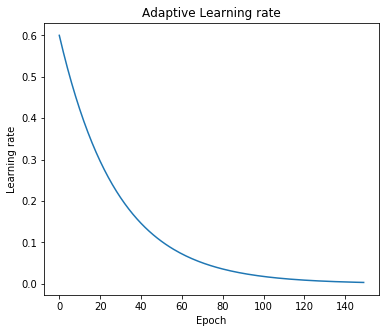

In [24]:
fig = plt.figure(figsize=(6, 5))
plt.plot(lr_list)
plt.title('Adaptive Learning rate')
plt.ylabel('Learning rate')
plt.xlabel('Epoch')
plt.show()

In [25]:
models = {
    'Base': base_model,
    'Drop + Reg': reg_drop_model,
    'Drop + Reg + A_lr': reg_drop_adaptive_model,
    'Adaptive lr': reg_model,
}

In [26]:
def plot_curves(title, data, y_title, x_title='Epoch', legend=[], x_labels_offset = 0):
    fig = plt.figure(figsize=(8, 4))
        
    for row in data:
        x = range(x_labels_offset, len(row))
        plt.plot(x, row[x_labels_offset:])
    
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.grid(True)
    plt.legend(legend, loc='upper left')
    plt.show()

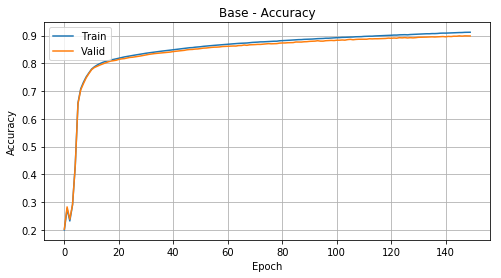

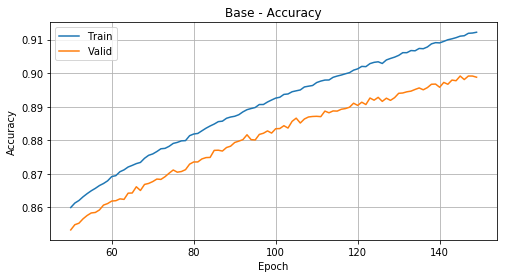

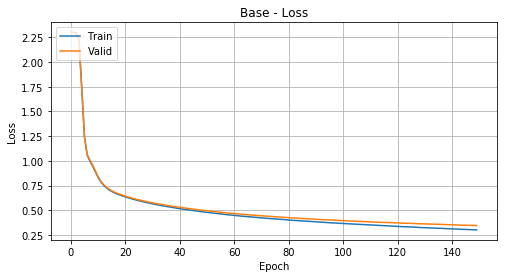

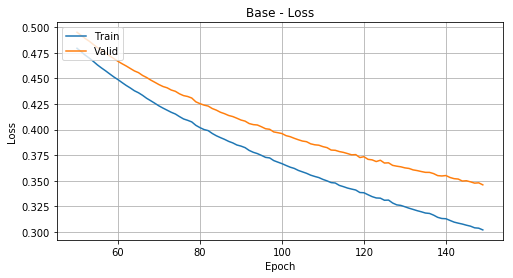

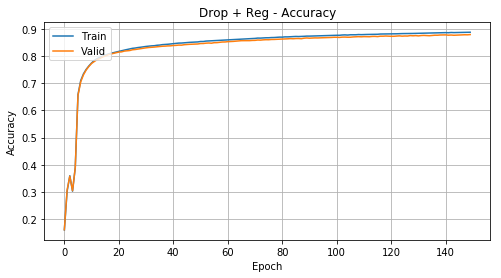

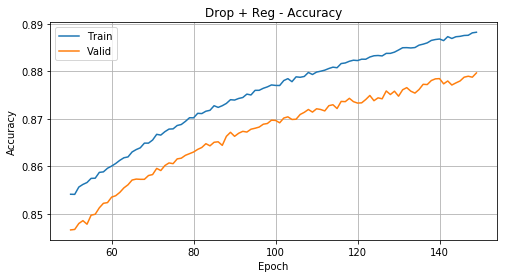

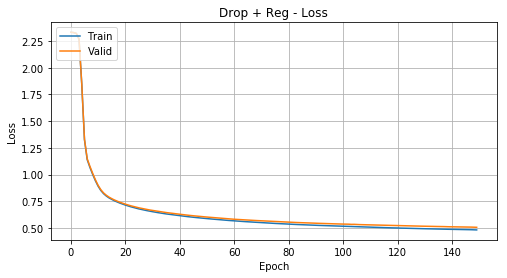

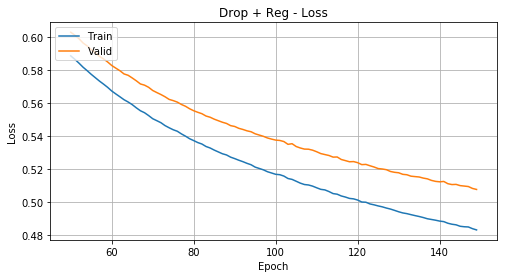

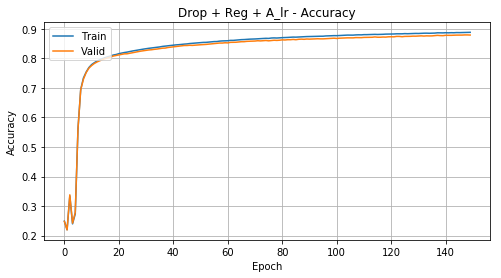

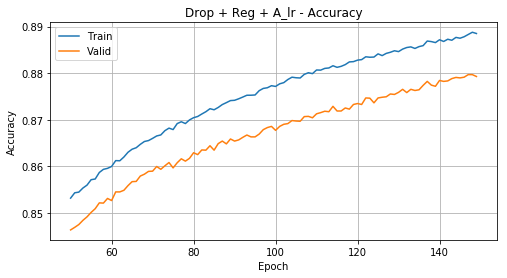

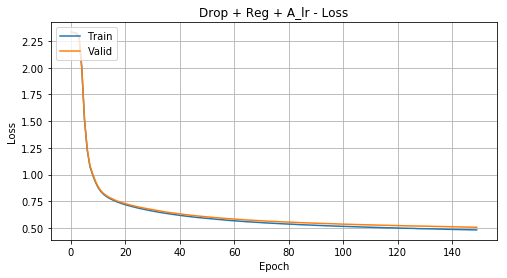

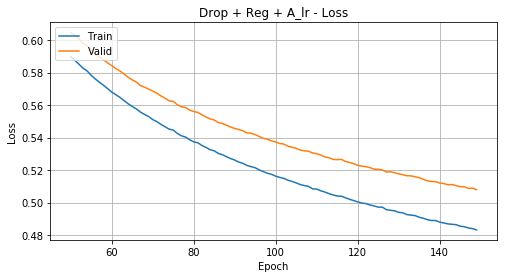

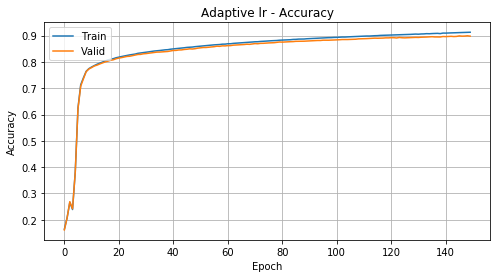

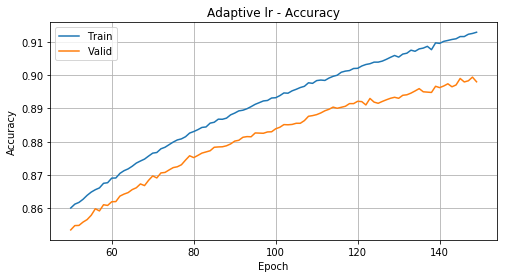

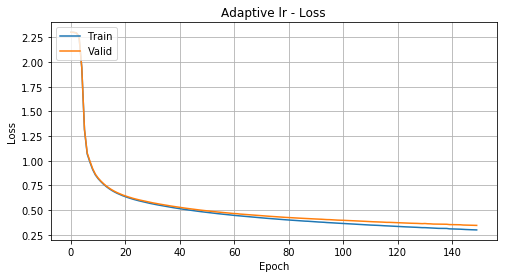

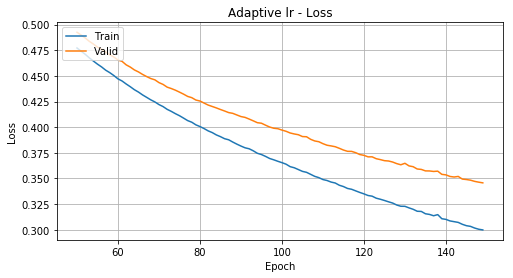

In [27]:
for name in models:
    offset = 50
    m = models[name]
    
    plot_curves(f'{name} - Accuracy', [m.history['acc_train'], m.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'])
    plot_curves(f'{name} - Accuracy', [m.history['acc_train'], m.history['acc_valid']], 'Accuracy', 'Epoch', ['Train', 'Valid'], x_labels_offset=offset)
    plot_curves(f'{name} - Loss', [m.history['loss_train'], m.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'])
    plot_curves(f'{name} - Loss', [m.history['loss_train'], m.history['loss_valid']], 'Loss', 'Epoch', ['Train', 'Valid'], x_labels_offset=offset)

In [28]:
loses = list()
acc = list()
labels = list()
for name in models:
    m = models[name]
    labels.append(name)
    loses.append(m.history['loss_valid'])
    acc.append(m.history['acc_valid'])

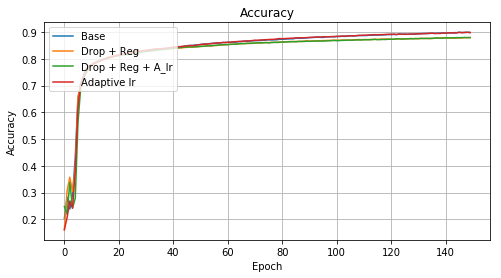

In [29]:
plot_curves(f'Accuracy', acc, 'Accuracy', 'Epoch', labels, x_labels_offset=0)

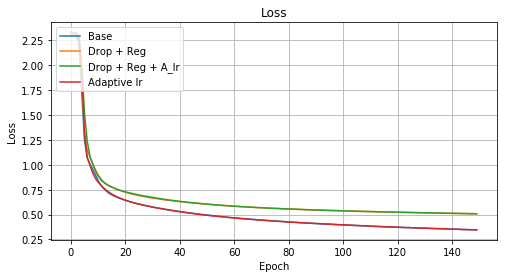

In [30]:
plot_curves(f'Loss', loses, 'Loss', 'Epoch', labels, x_labels_offset=0)

In [31]:
labels = list()
test_acc = list()
for name in models:
    m = models[name]
    labels.append(name)
    _, t_acc = m.evaluate(test_X, test_y)
    test_acc.append(t_acc)

labels, test_acc

(['Base', 'Drop + Reg', 'Drop + Reg + A_lr', 'Adaptive lr'],
 [0.94758195, 0.9431955, 0.9422086, 0.9459919])

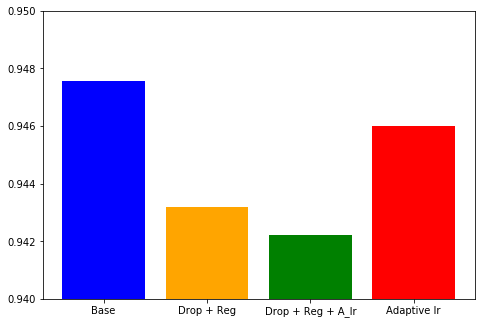

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,test_acc, color=['Blue', 'Orange', 'Green', 'Red'])
plt.ylim(0.94, 0.95)
plt.show()